<a href="https://colab.research.google.com/github/giovanni-lucarelli/distribution-shift/blob/main/GAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install pygam

In [56]:
import pandas as pd
from pygam import LinearGAM, s, te, f, LogisticGAM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score


In [57]:
# Load the training and testing datasets

df_train = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/train.csv')
df_test_95 = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/test_0.95.csv')
df_test_97 = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/test_0.97.csv')
df_test_99 = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/test_0.99.csv')

# Regression GAM

## Train

In [58]:
# Extract features and target
X_train = df_train[['x', 'y']].values
y_train = df_train['z'].values

In [59]:
# Define the base GAM model without
gam = LinearGAM(s(0) + s(1))

# Define the range of smoothing values to test for each term
lam_values = np.logspace(-3, 3, 10)  # Test smoothing parameters from 0.001 to 1000

# Perform grid search
gam.gridsearch(X_train, y_train, lam=lam_values)

# Print the optimal smoothing parameters
print("Best Lambda for each term:", gam.lam)


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Best Lambda for each term: [[10.0], [10.0]]


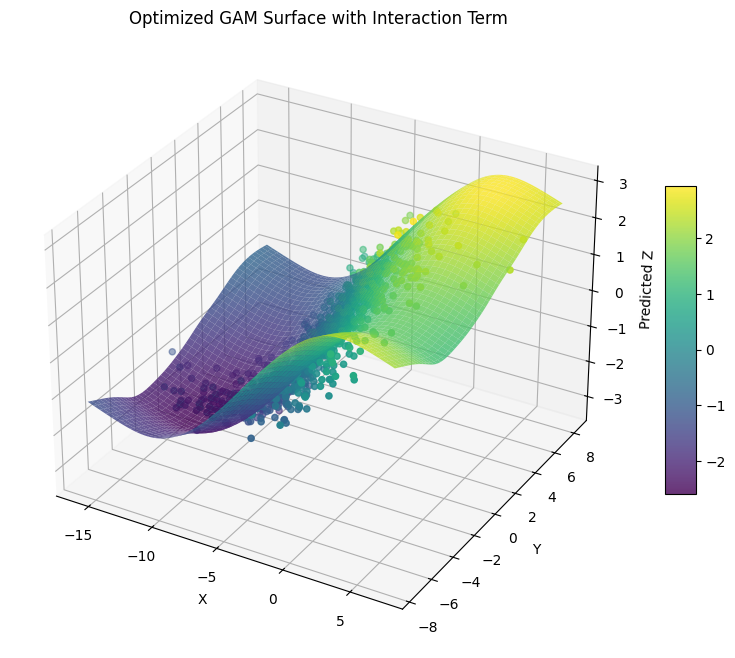

In [60]:
# Plot the surface
x_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
y_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Predict using the optimized GAM model on the grid
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
z_pred = gam.predict(X_grid).reshape(x_grid.shape)

# Surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_grid, y_grid, z_pred, cmap='viridis', alpha=0.8)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.scatter(df_train['x'], df_train['y'], df_train['z'], c=df_train['z'], cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Predicted Z')
ax.set_title('Optimized GAM Surface with Interaction Term')

plt.show()

## Test

In [61]:
for df_test in [df_test_95, df_test_97, df_test_99]:
  X_test = df_test[['x', 'y']].values
  y_test = df_test['z'].values

  # Predict on the test set using the optimized GAM
  y_pred = gam.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error on test set: {mse}")


Mean Squared Error on test set: 0.10846420214415799
Mean Squared Error on test set: 0.1205816785771146
Mean Squared Error on test set: 0.17928589255728916


# Binary Classification

In [62]:
# Define features and target
X_train = df_train[['x', 'y']]
y_train = df_train['t']

# Fit the model
gam = LogisticGAM(s(0) + s(1))
gam.fit(X_train, y_train)


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

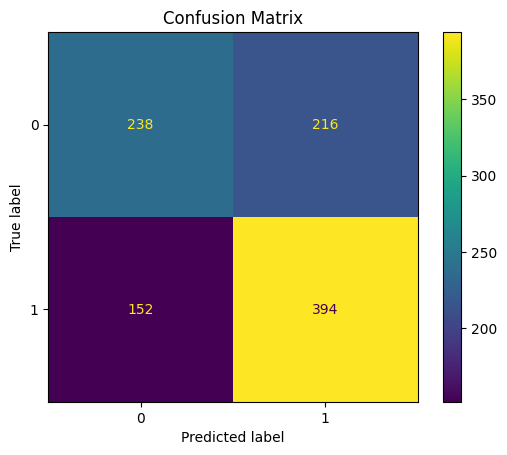

Accuracy: 0.63
False Positive Rate (FPR): 0.48
False Negative Rate (FNR): 0.28
Area Under Curve (AUC): 0.69


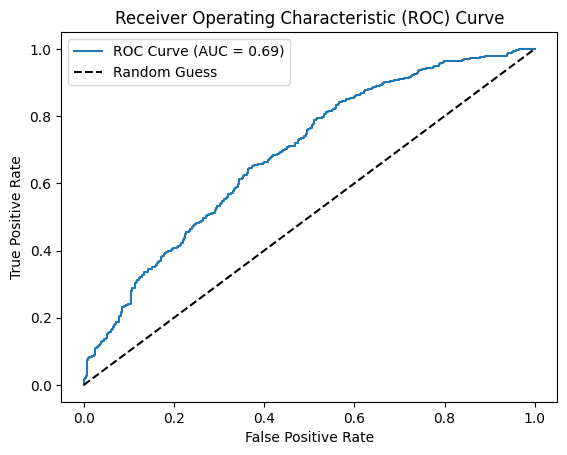

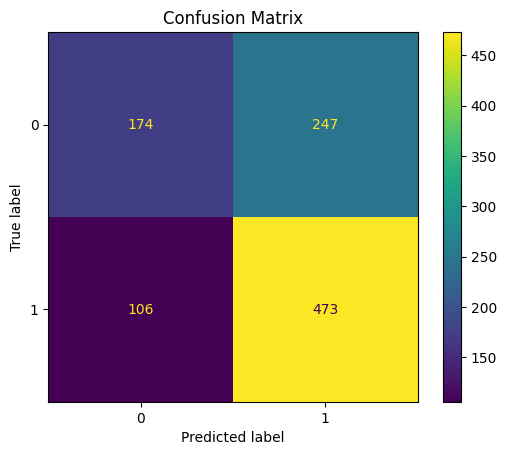

Accuracy: 0.65
False Positive Rate (FPR): 0.59
False Negative Rate (FNR): 0.18
Area Under Curve (AUC): 0.67


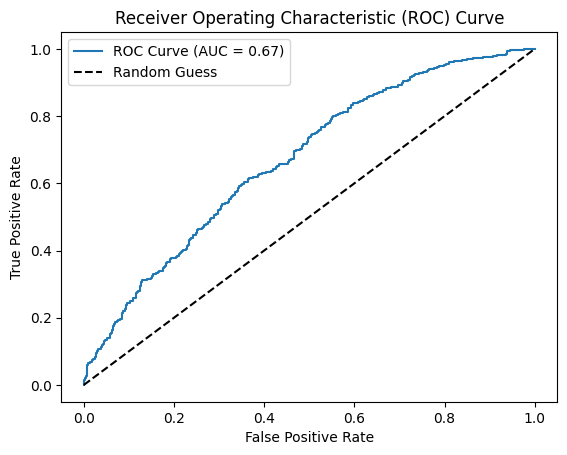

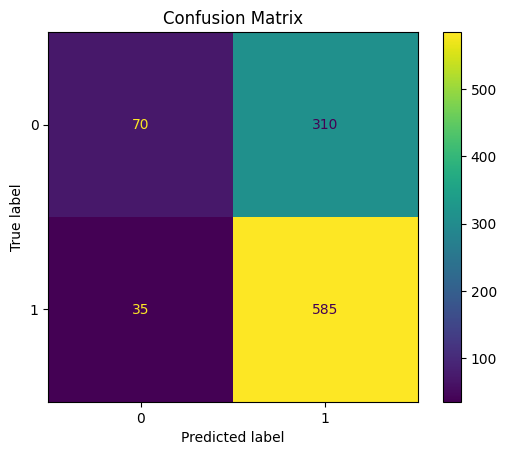

Accuracy: 0.66
False Positive Rate (FPR): 0.82
False Negative Rate (FNR): 0.06
Area Under Curve (AUC): 0.65


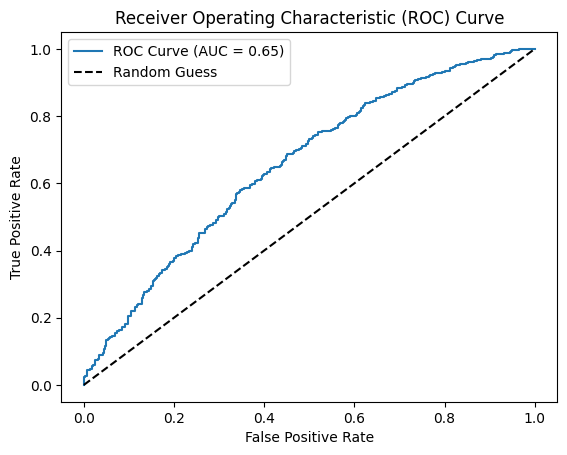

In [66]:
for df_test in [df_test_95, df_test_97, df_test_99]:
  X_test = df_test[['x', 'y']]
  y_test = df_test['t']

  # Make predictions on the test dataset
  y_pred = gam.predict(X_test)
  y_prob = gam.predict_proba(X_test)
  # Generate the confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Display the confusion matrix
  ConfusionMatrixDisplay(confusion_matrix=cm).plot()
  plt.title('Confusion Matrix')
  plt.show()

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')

  # Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
  fp = cm[0][1]
  fn = cm[1][0]
  tn = cm[0][0]
  tp = cm[1][1]

  fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
  fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

  print(f'False Positive Rate (FPR): {fpr:.2f}')
  print(f'False Negative Rate (FNR): {fnr:.2f}')

  # Calculate ROC curve and AUC
  fpr_values, tpr_values, thresholds = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr_values, tpr_values)

  print(f'Area Under Curve (AUC): {roc_auc:.2f}')

  # Plot ROC curve
  plt.figure()
  plt.plot(fpr_values, tpr_values, label=f'ROC Curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.show()
